## Introduction

Howard County is frequently cited for its affluence, quality of life, and excellent schools. Its estimated 2016 median household income of $120,194 raised it to the second-highest median household income of any U.S. county. Many of the most affluent communities in the area, such as Clarksville, Dayton, Glenelg, Glenwood, and West Friendship, are located along the Route 32 corridor in Howard County. The main population center of Columbia/Ellicott City was named second among Money magazine's 2010 survey of "America's Best Places to Live."  

As the county continues to expand and the population continues to grow, there are certain, less-populated areas that are underserved by restaurants.   Since many people must travel to other locations to dine out and get take-out food, traffic in some areas has greatly increased and the wait times at many restaurants continue to grow.  

These factors combine to suggest that certain areas of Howard County constitute prime locations in which to open a new restaurant.  However, that decision must factor in the competition as well as the number of potential customers for the new restaurant.  

To that end, we propose an analytical approach that examines the main neighborhoods of the county, as designated by zip code, the numbers and types of venues in each, and the population.  Based on a clustering of these factors, we will identify the best choice or choices for a new restaurant.

## Data Sources

Howard County maintains an online repository of data about the county (https://data.howardcountymd.gov/).  That cite provides the primary information about the neighborhoods and corresponding population numbers.  In addition, Foursquare.com, an online service that provides location information, is used to identify the types and number of venues in each of the areas.  Finally, the Folium Python library will be used to display maps of the area and to identify the location of clusters.

The data will be used to cluster neighborhoods according to the types of venues located in them as well as the popluation.  The goal will be to find the cluster with the fewest restaurants and the highest population.

## Import Required Libraries

Important libraries include:
* Requests:  for making API calls and receiving results
* Geocoder:  for geocoding addresses
* Folium:    for creating and displaying maps
* Sklearn:   Scikit-Learn library for machine learning algoritms and utilities


In [19]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


## Find Starting Zip Code

In [20]:
address = 'Columbia, Maryland'
locator = Nominatim(user_agent='myGeocoder')
location = locator.geocode(address)
print('Latitude = {}, Longitude = {}'.format(location.latitude, location.longitude))
latitude_n1=location.latitude
longitude_n1 = location.longitude

Latitude = 39.193919550000004, Longitude = -76.87477229012376


## Initialize Foursquare Parameters

In [21]:
CLIENT_ID = 'EDS1WXC30RRBFQPMHY215FNCZ04EAEKKS5KMLNZICBF0F1IY' # your Foursquare ID
CLIENT_SECRET = 'PPZCQD24CKM5CBLWQE3ZZ25ZA4Z333HFJNUI21NL5FMM13XW' # your Foursquare Secret
ACCESS_TOKEN = 'O1DPXUYLG0W44VKNBJODKTWAD20VLADNF5ONCFEECNAGZYJY' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EDS1WXC30RRBFQPMHY215FNCZ04EAEKKS5KMLNZICBF0F1IY
CLIENT_SECRET:PPZCQD24CKM5CBLWQE3ZZ25ZA4Z333HFJNUI21NL5FMM13XW


## Load Zip Codes and Geocode

The first step in the process is to load a spreadsheet of zipcodes and neighborhoods from the Howard County web site.  Next we use geocoder to find the latitude and longitude and combine them into the data frame.

In [22]:
colZips = pd.read_csv('C:/Users/John/Desktop/FinalProject/ColMDZipcodes.csv')
colZips = colZips.drop('geom', axis=1)


from geopy.extra.rate_limiter import RateLimiter
df=colZips
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
df['location'] = df['AREANAME'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)

## Display Initial Location Data Set



In [23]:
#df

## Initial Map of the Area

We can see the initial plot of the maps with each of the neighborhood locations.

In [24]:
map_columbia = folium.Map(location=[latitude_n1, longitude_n1], zoom_start=10)
# adding markers to map
for index,  row in df.iterrows():
    latitude = pd.to_numeric(row['latitude'])
    longitude = pd.to_numeric(row['longitude'])
    folium.CircleMarker(
        [latitude, longitude],
        radius=8,
        color='red',
        fill=True
        ).add_to(map_columbia)  
    
map_columbia    

## Plot Population by Zip Code

The Howard County data spreadsheet also provides population by neighborhood.  The following bar chart illustrates to popluation values.  We can see that Ellicott City and Columbia are the most highly populated.

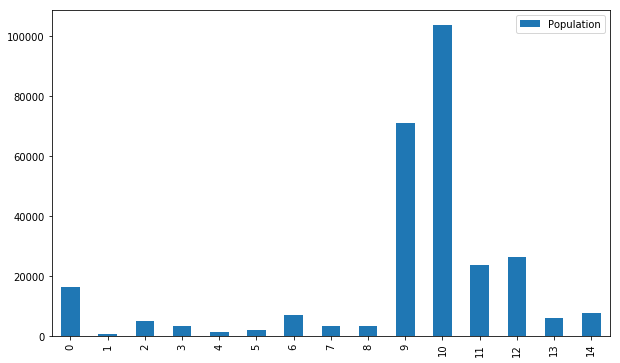

In [25]:
df_bars = df[["AREANAME", "Population"]]
df_bars.head()
df_bars.plot(kind='bar', figsize=(10, 6))

## Scale Population Values

Because the K-Means algorithm computes distances, it is important that we scale the population data.  This is performed using the preprocessing library from Scikit-Learn.

In [26]:
from sklearn import preprocessing
pop_values = df['Population']
pop_values = pd.DataFrame(pop_values)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(pop_values)
x_scaled
df['pop_scaled'] = x_scaled
#pop_scaled = pd.DataFrame(x_scaled,
#columns=movie_dummy_set.columns)
df.head()

,ZIPCODE,AREANAME,Population,location,point,latitude,longitude,altitude,pop_scaled
0,21794,"West Friendship, Maryland",16360,"(West Friendship, Howard County, Maryland, 217...","(39.3034518, -76.9537905, 0.0)",39.303452,-76.953790,0.0,0.151573
1,21723,"Cooksville, Maryland",803,"(Cooksville, Howard County, Maryland, 21723, U...","(39.3201044, -77.0205346, 0.0)",39.320104,-77.020535,0.0,0.000000
2,20833,"Brookeville, Maryland",5062,"(Brookeville, Montgomery County, Maryland, Uni...","(39.1807943, -77.0591072, 0.0)",39.180794,-77.059107,0.0,0.041496
3,21738,"Glenwood, Maryland",3286,"(Glenwood, Harford County, Maryland, 21015, Un...","(39.5153855, -76.3219032, 0.0)",39.515386,-76.321903,0.0,0.024192
4,21737,"Glenelg, Maryland",1458,"(Glenelg, Howard County, Maryland, 21737, Unit...","(39.2644382, -76.9899134, 0.0)",39.264438,-76.989913,0.0,0.006382


## Find Nearby Venues

The next few steps involve using the Foursquare API to find nocations that are near out Columbia starting location.  

In [27]:
radius = 7000 
LIMIT = 100

#print(latitude_n1)
#print(longitude_n1)
near = 'Columbia, MD'

#venues/explore?near=Columbia, MD

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    near,
    radius, 
    LIMIT)
results = requests.get(url).json()
#results

First we call the function to get the nearby venues.  Because the API responds with JSON, we need to parse out the interesting fields.  We also create a function to develop the list of categories.

In [28]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
#nearby_venues.columns

In [29]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Display Venues

Next we display the first few rows of the dataframe that contains the venue names and coordinates.  The categorie of each will be parsed out below.

In [30]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,LeeLynn's Dining Room and Lounge,"[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",39.240539,-76.839905
1,"YOU salon, Inc","[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",39.242084,-76.839086
2,Centennial Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",39.240008,-76.860664
3,Sapwood Cellars,"[{'id': '50327c8591d4c4b30a586d5d', 'name': 'B...",39.229243,-76.823102
4,The Honey Baked Ham Company,"[{'id': '4bf58dd8d48988d146941735', 'name': 'D...",39.242547,-76.842217


## Display Venue Categories and Locations

The dataframe, displayed below, shows the resulting values with the name, category and coordinates.

In [31]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)


,name,categories,lat,lng
0,LeeLynn's Dining Room and Lounge,American Restaurant,39.240539,-76.839905
1,"YOU salon, Inc",Cosmetics Shop,39.242084,-76.839086
2,Centennial Park,Park,39.240008,-76.860664
3,Sapwood Cellars,Brewery,39.229243,-76.823102
4,The Honey Baked Ham Company,Deli / Bodega,39.242547,-76.842217


## List Most Frequently Occurring Categories

It is interesting to note that cosmetic shops appear at the top of the list.  Another thing to note is that we limited the Foursquare results to 100 venues. 

In [32]:
a=pd.Series(nearby_venues.categories)
a.value_counts().head()

Cosmetics Shop          5
American Restaurant     5
Bakery                  4
Fast Food Restaurant    3
Sandwich Place          3
Name: categories, dtype: int64

## Create Function to Find Venues Near Neighborhoods

The function defined below calls the Foursquare API for each of the neighborhoods in out data set.  It returns the results and creates a dataframe that contains the neighborhood, the venue, the category, and the coordinates.  

In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=7000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

## Execute Function to Find Venues Near Locations

Now we call the above function for the neighborhoods in our data set.

In [34]:
venues_in_columbia = getNearbyVenues(df['AREANAME'], df['latitude'], df['longitude'])

West Friendship, Maryland 
Cooksville, Maryland
Brookeville, Maryland
Glenwood, Maryland
Glenelg, Maryland
Dayton, Maryland
Woodstock, Maryland
Highland, Maryland
Fulton, Maryland
Ellicott City, Maryland
Columbia, Maryland
Laurel, Maryland
Hanover, Maryland
Savage, Maryland
Jessup, Maryland


In the dataframe below we see the first five venues/categories for each neighborhood.

In [35]:
venues_in_columbia.groupby('Neighborhood').head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
0,"West Friendship, Maryland",39.303452,-76.953790,Breezy Willow Farm & CSA,Farm
1,"West Friendship, Maryland",39.303452,-76.953790,Howard County Fairgrounds,Other Great Outdoors
2,"West Friendship, Maryland",39.303452,-76.953790,Petite Cellars,Wine Shop
3,"West Friendship, Maryland",39.303452,-76.953790,Ten Oaks Tavern,Bar
4,"West Friendship, Maryland",39.303452,-76.953790,Woodstock Snowball Stand,Ice Cream Shop
30,"Cooksville, Maryland",39.320104,-77.020535,Dunkin',Donut Shop
31,"Cooksville, Maryland",39.320104,-77.020535,Western Regional Park & Gary J. Arthur Communi...,Park
32,"Cooksville, Maryland",39.320104,-77.020535,Glenwood Community Center,Gym / Fitness Center
33,"Cooksville, Maryland",39.320104,-77.020535,Breezy Willow Farm & CSA,Farm
34,"Cooksville, Maryland",39.320104,-77.020535,Cattail Creek Country Club,Golf Course


## List Category Counts in Descending Order

We also summarize and sort all of the venues in descending order.  As a preliminary answer to the business question we can see that sandwich places, American restaurants, Mexican restaurants, Italian restaurants occur the most out of the restaurant categories.  These would not be good category choices for a new venue.

In [36]:
#venues_in_columbia.groupby('Venue Category').max()
venue_count = venues_in_columbia.groupby('Venue Category').count()
venue_count = pd.DataFrame(venue_count)
#venue_count 
venue_count.sort_values(by='Venue', ascending=False)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue
Venue Category,,,,
Sandwich Place,18,18,18,18
American Restaurant,15,15,15,15
Park,13,13,13,13
Ice Cream Shop,12,12,12,12
Golf Course,12,12,12,12
Mexican Restaurant,12,12,12,12
Bakery,11,11,11,11
Italian Restaurant,10,10,10,10
Pizza Place,10,10,10,10


In [37]:
print('There are {} Uniques Categories.'.format(len(venues_in_columbia['Venue Category'].unique())))
#venues_in_columbia.groupby('Neighbourhood').count()

There are 125 Uniques Categories.


## Perform One-Hot Encoding

One-hot encoding converts categorical variables into numeric variables for use by K-Means

In [38]:
# one hot encoding
Columbia_onehot = pd.get_dummies(venues_in_columbia[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Columbia_onehot['Neighborhood'] = venues_in_columbia['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Columbia_onehot.columns[-1]] + list(Columbia_onehot.columns[:-1])
Columbia_onehot = Columbia_onehot[fixed_columns]
Columbia_grouped = Columbia_onehot.groupby('Neighborhood').mean().reset_index()
Columbia_onehot.head(10)

,Wings Joint,Afghan Restaurant,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Store,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dam,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Farm,Farmers Market,Fast Food Restaurant,Fondue Restaurant,Food & Drink Shop,Food Service,Forest,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,General Entertainment,German Restaurant,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,History Museum,Hobby Shop,Hotel,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Martial Arts School,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mongolian Restaurant,Mountain,Movie Theater,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Night Market,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Portuguese Restaurant,Post Office,Pub,Residential Building (Apartment / Condo),Restaurant,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Spa,Sporting Goods Shop,State / Provincial Park,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Theater,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"West Friendship, Maryland",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"West Friendship, Maryland",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"West Friendship, Maryland",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"West Friendship, Maryland",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"West Friendship, Maryland",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"West Friendship, Maryland",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"West Friendship, Maryland",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"West Friendship, Maryland",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Determine Most Common Venues by Area

Below we create a function to determine the most common venues by neighborhood.  Then, for each neighborhood we determine the 10 most common venues in descending order.  This information will become key to our decision making. 

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
import numpy as np
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Columbia_grouped['Neighborhood']
for ind in np.arange(Columbia_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Columbia_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Brookeville, Maryland",Sandwich Place,Mexican Restaurant,Salon / Barbershop,Burger Joint,Brewery,Italian Restaurant,Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Food Service
1,"Columbia, Maryland",Cosmetics Shop,Ice Cream Shop,Asian Restaurant,New American Restaurant,Chinese Restaurant,Chocolate Shop,Pharmacy,Department Store,Park,Music Venue
2,"Cooksville, Maryland",American Restaurant,Donut Shop,Farm,Post Office,Bar,Sandwich Place,Golf Course,Park,Other Great Outdoors,Night Market
3,"Dayton, Maryland",Spa,Gym / Fitness Center,Dam,Shop & Service,Shoe Store,Seafood Restaurant,Burger Joint,Sandwich Place,Grocery Store,Pharmacy
4,"Ellicott City, Maryland",American Restaurant,Café,State / Provincial Park,Pharmacy,Pub,Mexican Restaurant,Pizza Place,French Restaurant,Korean Restaurant,Brewery
5,"Fulton, Maryland",Ice Cream Shop,Supermarket,Indian Restaurant,Park,Pizza Place,Asian Restaurant,Bubble Tea Shop,Gym,Hotel,Italian Restaurant
6,"Glenelg, Maryland",Gas Station,Park,Sandwich Place,Seafood Restaurant,Donut Shop,Gym / Fitness Center,Ice Cream Shop,Wine Shop,Golf Course,Lake
7,"Glenwood, Maryland",Sandwich Place,Pizza Place,Shopping Mall,Café,Clothing Store,Coffee Shop,Convenience Store,Grocery Store,Pharmacy,Dessert Shop
8,"Hanover, Maryland",State / Provincial Park,Fast Food Restaurant,Toy / Game Store,Hotel,French Restaurant,Deli / Bodega,Movie Theater,Portuguese Restaurant,Coffee Shop,Rock Club
9,"Highland, Maryland",Golf Course,Trail,Winery,Farm,Fast Food Restaurant,Seafood Restaurant,Pet Store,Scenic Lookout,State / Provincial Park,Forest


## Perform K-Means Clustering

Next we perform the K-Means clustering on the data set.  We drop the neighborhood column from the input data since it is categorical rather than numeric.  Following that we merge the resulting cluster labels into the previously combined data set.

In [42]:
Columbia_grouped_clustering = Columbia_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Columbia_grouped_clustering)
#kmeans.labels_


## Merge Cluster Labels with Data

In [43]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Columbia_merged =df.iloc[:16,:]
Columbia_merged.head()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Columbia_merged = Columbia_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='AREANAME')

Columbia_merged.head()# check the last columns!

,ZIPCODE,AREANAME,Population,location,point,latitude,longitude,altitude,pop_scaled,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,21794,"West Friendship, Maryland",16360,"(West Friendship, Howard County, Maryland, 217...","(39.3034518, -76.9537905, 0.0)",39.303452,-76.953790,0.0,0.151573,0,Donut Shop,Park,American Restaurant,Golf Course,Sandwich Place,Ice Cream Shop,Spa,Department Store,Creperie,Post Office
1,21723,"Cooksville, Maryland",803,"(Cooksville, Howard County, Maryland, 21723, U...","(39.3201044, -77.0205346, 0.0)",39.320104,-77.020535,0.0,0.000000,0,American Restaurant,Donut Shop,Farm,Post Office,Bar,Sandwich Place,Golf Course,Park,Other Great Outdoors,Night Market
2,20833,"Brookeville, Maryland",5062,"(Brookeville, Montgomery County, Maryland, Uni...","(39.1807943, -77.0591072, 0.0)",39.180794,-77.059107,0.0,0.041496,1,Sandwich Place,Mexican Restaurant,Salon / Barbershop,Burger Joint,Brewery,Italian Restaurant,Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Food Service
3,21738,"Glenwood, Maryland",3286,"(Glenwood, Harford County, Maryland, 21015, Un...","(39.5153855, -76.3219032, 0.0)",39.515386,-76.321903,0.0,0.024192,1,Sandwich Place,Pizza Place,Shopping Mall,Café,Clothing Store,Coffee Shop,Convenience Store,Grocery Store,Pharmacy,Dessert Shop
4,21737,"Glenelg, Maryland",1458,"(Glenelg, Howard County, Maryland, 21737, Unit...","(39.2644382, -76.9899134, 0.0)",39.264438,-76.989913,0.0,0.006382,0,Gas Station,Park,Sandwich Place,Seafood Restaurant,Donut Shop,Gym / Fitness Center,Ice Cream Shop,Wine Shop,Golf Course,Lake


## Map Clusters

Next we plot the cluster locations on the map.  Which cluster a neighborhood belongs to is indicated by the color of the cicle.

In [48]:
kclusters=10
map_clusters = folium.Map(location=[39.1939, -76.8748], zoom_start=11)
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, nei , cluster in zip(Columbia_merged['latitude'], 
                                   Columbia_merged['longitude'], 
                                   Columbia_merged['AREANAME'], 
                                   Columbia_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
      
map_clusters

## Display the Resulting Cluster Information

### Cluster 1

In [49]:
Columbia_merged.loc[Columbia_merged['Cluster Labels'] == 0, Columbia_merged.columns[[1] + list(range(5, Columbia_merged.shape[1]))]]

,AREANAME,latitude,longitude,altitude,pop_scaled,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"West Friendship, Maryland",39.303452,-76.953790,0.0,0.151573,0,Donut Shop,Park,American Restaurant,Golf Course,Sandwich Place,Ice Cream Shop,Spa,Department Store,Creperie,Post Office
1,"Cooksville, Maryland",39.320104,-77.020535,0.0,0.000000,0,American Restaurant,Donut Shop,Farm,Post Office,Bar,Sandwich Place,Golf Course,Park,Other Great Outdoors,Night Market
4,"Glenelg, Maryland",39.264438,-76.989913,0.0,0.006382,0,Gas Station,Park,Sandwich Place,Seafood Restaurant,Donut Shop,Gym / Fitness Center,Ice Cream Shop,Wine Shop,Golf Course,Lake
7,"Highland, Maryland",39.520934,-77.518043,0.0,0.024465,0,Golf Course,Trail,Winery,Farm,Fast Food Restaurant,Seafood Restaurant,Pet Store,Scenic Lookout,State / Provincial Park,Forest


### Cluster 2

In [46]:
Columbia_merged.loc[Columbia_merged['Cluster Labels'] == 1, Columbia_merged.columns[[1] + list(range(5, Columbia_merged.shape[1]))]]

,AREANAME,latitude,longitude,altitude,pop_scaled,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Brookeville, Maryland",39.180794,-77.059107,0.0,0.041496,1,Sandwich Place,Mexican Restaurant,Salon / Barbershop,Burger Joint,Brewery,Italian Restaurant,Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Food Service
3,"Glenwood, Maryland",39.515386,-76.321903,0.0,0.024192,1,Sandwich Place,Pizza Place,Shopping Mall,Café,Clothing Store,Coffee Shop,Convenience Store,Grocery Store,Pharmacy,Dessert Shop
5,"Dayton, Maryland",39.239272,-76.986644,0.0,0.012773,1,Spa,Gym / Fitness Center,Dam,Shop & Service,Shoe Store,Seafood Restaurant,Burger Joint,Sandwich Place,Grocery Store,Pharmacy
6,"Woodstock, Maryland",39.324122,-76.855615,0.0,0.060631,1,State / Provincial Park,Mexican Restaurant,Korean Restaurant,Bakery,BBQ Joint,Golf Course,Italian Restaurant,Wine Shop,Liquor Store,Bubble Tea Shop
8,"Fulton, Maryland",39.150941,-76.923031,0.0,0.024864,1,Ice Cream Shop,Supermarket,Indian Restaurant,Park,Pizza Place,Asian Restaurant,Bubble Tea Shop,Gym,Hotel,Italian Restaurant
9,"Ellicott City, Maryland",39.267328,-76.798307,0.0,0.681791,1,American Restaurant,Café,State / Provincial Park,Pharmacy,Pub,Mexican Restaurant,Pizza Place,French Restaurant,Korean Restaurant,Brewery
11,"Laurel, Maryland",39.099275,-76.848306,0.0,0.222015,1,Burger Joint,Wine Shop,Mexican Restaurant,BBQ Joint,Ice Cream Shop,Farmers Market,Seafood Restaurant,Café,Sandwich Place,Chinese Restaurant


### Cluster 3

In [47]:
Columbia_merged.loc[Columbia_merged['Cluster Labels'] == 2, Columbia_merged.columns[[1] + list(range(5, Columbia_merged.shape[1]))]]

,AREANAME,latitude,longitude,altitude,pop_scaled,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,"Columbia, Maryland",39.193920,-76.874772,0.0,1.000000,2,Cosmetics Shop,Ice Cream Shop,Asian Restaurant,New American Restaurant,Chinese Restaurant,Chocolate Shop,Pharmacy,Department Store,Park,Music Venue
12,"Hanover, Maryland",39.192885,-76.724137,0.0,0.248750,2,State / Provincial Park,Fast Food Restaurant,Toy / Game Store,Hotel,French Restaurant,Deli / Bodega,Movie Theater,Portuguese Restaurant,Coffee Shop,Rock Club
13,"Savage, Maryland",39.122834,-76.796415,0.0,0.052291,2,Coffee Shop,Park,Shopping Mall,Ice Cream Shop,Farmers Market,Seafood Restaurant,Café,Cupcake Shop,Peruvian Restaurant,Department Store
14,"Jessup, Maryland",39.149275,-76.775249,0.0,0.066808,2,Grocery Store,Warehouse Store,Gym,Toy / Game Store,Coffee Shop,General Entertainment,Nail Salon,Peruvian Restaurant,Pet Store,Pizza Place


## Conclusion

The purpose of this exercise is to determine a neighborhood in Howard County, Maryland in which to open a new restaurant.  The select a candidate we located each of the neighborhoods on a map, used the Foursquare API to find nearby venues in each neighborhood.  We also determined the most frequently occurring categories in each neighborhood.  We used the k-Means clustering algorithm to group neighborhoods according to the types of venues and the scaled poplulation values.

Three clusters were created by the algorithm.  Cluster 2 is not a good choice since most of the top occurring categories are restaurants.  Cluster 1 is similarly not the best choice given the frequency of restaurants in the three or four top occurring categories.  Cluster 3 represents a good choice.  Other than a coffee shop and ice cream shop, there are no restaurants in the top occuring category and very few in the next several top occurring categories.  We also see that Cluster 3 does contain the highest scaled population values as well.
